# Strategies

In [1]:
import os
import re
import glob
import numpy as np
import pandas as pd
import talib
import matplotlib.pyplot as plt
import warnings
import quantstats as qs

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from skopt import gp_minimize
from skopt.space import Real
from numpy.fft import fft, fftfreq
from scipy.stats import kstest, normaltest, shapiro
from scipy.special import comb
from sklearn.model_selection import TimeSeriesSplit
from dataclasses import dataclass
from typing import List, Dict

warnings.simplefilter('ignore')

In [2]:
short_period = 6
long_period = 12

class MovingAverageStrategy:
    def __init__(self, short=short_period, long=long_period):
        self.short = short
        self.long = long
    def signal(self, index, series):
        x = series.values.astype(float)
        methods = ['EMA','SMA','WMA','DEMA','TEMA','TRIMA','KAMA']
        vals = []
        for m in methods:
            if m == 'EMA':
                a = talib.EMA(x, timeperiod=self.short)
                b = talib.EMA(x, timeperiod=self.long)
            elif m == 'SMA':
                a = talib.SMA(x, timeperiod=self.short)
                b = talib.SMA(x, timeperiod=self.long)
            elif m == 'WMA':
                a = talib.WMA(x, timeperiod=self.short)
                b = talib.WMA(x, timeperiod=self.long)
            elif m == 'DEMA':
                a = talib.DEMA(x, timeperiod=self.short)
                b = talib.DEMA(x, timeperiod=self.long)
            elif m == 'TEMA':
                a = talib.TEMA(x, timeperiod=self.short)
                b = talib.TEMA(x, timeperiod=self.long)
            elif m == 'TRIMA':
                a = talib.TRIMA(x, timeperiod=self.short)
                b = talib.TRIMA(x, timeperiod=self.long)
            elif m == 'KAMA':
                a = talib.KAMA(x, timeperiod=self.short)
                b = talib.KAMA(x, timeperiod=self.long)
            sig = (a - b) > 0
            vals.append(sig.astype(int))
        avg = np.nanmean(np.column_stack(vals), axis=1)
        return pd.DataFrame({'value': avg}, index=index)

In [3]:
lookback_period = 12
zscore_lookback_period = 72
signal_threshold = 0.75

class BetaRegressionStrategy:
    def __init__(self, beta_lookback_period=lookback_period, zscore_lookback_period=zscore_lookback_period, signal_threshold=signal_threshold):
        self.beta_lookback_period = beta_lookback_period
        self.zscore_lookback_period = zscore_lookback_period
        self.signal_threshold = signal_threshold
        
    def signal(self, index, low_series, high_series):
        x = pd.Series(low_series.values.astype(float), index=index)
        y = pd.Series(high_series.values.astype(float), index=index)
        w = self.beta_lookback_period
        mx = x.rolling(w).mean()
        my = y.rolling(w).mean()
        mxx = (x * x).rolling(w).mean()
        myy = (y * y).rolling(w).mean()
        mxy = (x * y).rolling(w).mean()
        varx = mxx - mx * mx
        vary = myy - my * my
        cov = mxy - mx * my
        beta_s = cov / varx
        corr = cov / (np.sqrt(varx) * np.sqrt(vary))
        r2_s = corr * corr
        z = (beta_s - beta_s.rolling(self.zscore_lookback_period).mean()) / beta_s.rolling(self.zscore_lookback_period).std()
        strength = z * r2_s
        weight = strength.where(beta_s > self.signal_threshold, 0.0)
        return pd.DataFrame({'value': weight}, index=index)

In [4]:
threshold = -1

class CLV:
    def __init__(self, threshold=threshold):
        self.threshold = threshold
    
    def signal(self, index, clv_series):
        y = (clv_series == self.threshold).fillna(0)
        return pd.DataFrame({'value': y.astype(int)}, index=index)  

In [5]:
ma_long = 50
ma_short = 20
breakout_lookback = 20
atr_period = 14

class BreakoutStrategy:
    def __init__(self, ma_long=ma_long, ma_short=ma_short, breakout_lookback=breakout_lookback, atr_period=atr_period):
        self.ma_long = ma_long
        self.ma_short = ma_short
        self.breakout_lookback = breakout_lookback
        self.atr_period = atr_period

    def signal(self, index: pd.DatetimeIndex,
               low_series: pd.Series,
               high_series: pd.Series) -> pd.DataFrame:
        close = (low_series + high_series) / 2.0

        ma_long = close.rolling(self.ma_long).mean()
        ma_short = close.rolling(self.ma_short).mean()

        high_n = close.rolling(self.breakout_lookback).max()
        low_n = close.rolling(self.breakout_lookback).min()

        prev_close = close.shift()
        tr1 = high_n - low_n
        tr2 = (high_n - prev_close).abs()
        tr3 = (low_n - prev_close).abs()
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        atr = tr.rolling(self.atr_period).mean()

        breakout_up = (close > ma_long) & (close > high_n.shift(1))
        breakout_down = (close < ma_short) & (close < low_n.shift(1))

        sig = pd.Series(0.0, index=index)
        sig.loc[breakout_up] = 1.0
        sig.loc[breakout_down] = -1.0

        sig_smooth = sig.rolling(window=self.ma_short, min_periods=1).mean().fillna(0.0)

        return pd.DataFrame({'value': sig_smooth.astype(float)}, index=index)

In [6]:
time_series_datapoints = 288
low_energy_threshold = 0.5
mid_energy_threshold = 0.1
low_slope_threshold = 0.0
mid_slope_threshold = 0.0


class FourierTransform:
    def __init__(self,
                 time_series_datapoints=time_series_datapoints,
                 low_energy_threshold=low_energy_threshold,
                 mid_energy_threshold=mid_energy_threshold,
                 low_slope_threshold=low_slope_threshold,
                 mid_slope_threshold=mid_slope_threshold):
        self.recents = int(time_series_datapoints)
        self.low_energy_threshold = float(low_energy_threshold)
        self.mid_energy_threshold = float(mid_energy_threshold)
        self.low_slope_threshold = float(low_slope_threshold)
        self.mid_slope_threshold = float(mid_slope_threshold)
        self.low_grid = np.arange(0.01, 0.09, 0.01)
        self.high_grid = np.arange(0.06, 0.21, 0.01)

    def discrete_fourier_transform(self, s: pd.Series, recents: int) -> pd.DataFrame:
        x = s.dropna().sort_index().tail(recents)
        n = len(x)
        if n == 0:
            return pd.DataFrame({"frequency": [], "magnitude": []})
        dt = 1.0
        y = x.values
        yf = fft(y)
        xf = fftfreq(n, d=dt)
        pos = xf > 0
        xf = xf[pos]
        mag = np.abs(yf)[pos]
        return pd.DataFrame({"frequency": xf, "magnitude": mag})

    def reconstruct_time_series(self, s: pd.Series,
                                low_filter: float,
                                high_filter: float,
                                band: str) -> pd.Series:
        x = s.dropna().sort_index()
        y = x.values
        n = len(x)
        if n == 0:
            return pd.Series([], dtype=float)

        F = np.fft.rfft(y, n=n)
        f = np.fft.rfftfreq(n, d=1.0)

        if band == "low":
            mask = f < low_filter
        elif band == "middle":
            mask = (f >= low_filter) & (f <= high_filter)
        else:
            mask = f > high_filter

        y_band = np.fft.irfft(F * mask, n=n)
        return pd.Series(y_band, index=x.index)

    def frequency_filter(self, spec_df: pd.DataFrame,
                         low_filter: float,
                         high_filter: float):
        d = spec_df.dropna()
        low = d[d["frequency"] < low_filter]
        mid = d[(d["frequency"] >= low_filter) & (d["frequency"] <= high_filter)]
        high = d[d["frequency"] > high_filter]
        return low, mid, high

    def normality_test(self, arr):
        x = np.asarray(arr)
        if len(x) < 8 or np.allclose(x.std(ddof=1), 0):
            return 1.0, 1.0, 1.0
        z = (x - x.mean()) / x.std(ddof=1)
        return (
            kstest(z, "norm").pvalue,
            normaltest(x).pvalue,
            shapiro(x).pvalue
        )

    def seasonality_test(self, spec_df: pd.DataFrame) -> float:
        d = spec_df.dropna()
        if len(d) == 0:
            return 1.0
        p = (d["magnitude"].values ** 2)
        mx = float(p.max())
        tot = float(p.sum())
        g = mx / tot if tot > 0 else 0.0
        m = len(p)
        if g <= 0 or m <= 1:
            return 1.0
        kmax = int(np.floor(1.0 / g)) if g > 0 else 0
        pv = 0.0
        for k in range(1, kmax + 1):
            pv += ((-1)**(k-1)) * comb(m, k, exact=False) * (1 - k*g)**(m-1)
        return float(pv)

    def compute_energy(self, spec_df: pd.DataFrame,
                       low_filter: float,
                       high_filter: float):
        d = spec_df.dropna()
        if len(d) == 0:
            return 0.0, 0.0, 0.0
        f = d["frequency"].values
        m2 = (d["magnitude"].values ** 2)
        low = float(m2[f < low_filter].sum())
        mid = float(m2[(f >= low_filter) & (f < high_filter)].sum())
        high = float(m2[f >= high_filter].sum())
        tot = low + mid + high
        if tot > 0:
            low /= tot
            mid /= tot
            high /= tot
        return low, mid, high

    def compute_slope(self, s: pd.Series, inst_regression: int) -> float:
        y = s.dropna().tail(inst_regression).values
        if len(y) < 2:
            return 0.0
        X = np.arange(len(y)).reshape(-1, 1)
        return float(LinearRegression().fit(X, y).coef_[0])

    def choose_filter_bound(self, s: pd.Series,
                            spec_df: pd.DataFrame,
                            low_grid,
                            high_grid):
        for low in low_grid:
            for high in high_grid:
                if high <= low:
                    continue
                hf = self.reconstruct_time_series(s, low, high, "high")
                r = pd.Series(hf).diff().dropna()
                p1, p2, p3 = self.normality_test(r)

                _, mid_spec, _ = self.frequency_filter(spec_df, low, high)
                pv_season = self.seasonality_test(mid_spec)

                if (p1 < 0.05) and (p2 < 0.05) and (p3 < 0.05) and (pv_season < 0.05):
                    return float(low), float(high)
        return None

    def signal(self, index: pd.DatetimeIndex,
               vwap_series: pd.Series) -> pd.DataFrame:
        s = vwap_series.dropna().sort_index()
        s = np.log(s[s > 0])

        if len(s) < self.recents:
            return pd.DataFrame({'value': pd.Series(0.0, index=index)})

        spec_last = self.discrete_fourier_transform(s, self.recents)
        chosen = self.choose_filter_bound(s, spec_last, self.low_grid, self.high_grid)
        if chosen is None:
            return pd.DataFrame({'value': pd.Series(0.0, index=index)})

        low_f, high_f = chosen
        weights = pd.Series(0.0, index=s.index, dtype=float)

        step = self.recents
        inst_reg = max(8, self.recents // 6)

        for t in range(self.recents, len(s) + 1, step):
            sw = s.iloc[:t].tail(self.recents)
            spec_t = self.discrete_fourier_transform(sw, self.recents)
            el, em, eh = self.compute_energy(spec_t, low_f, high_f)

            low_ts = self.reconstruct_time_series(sw, low_f, high_f, "low")
            mid_ts = self.reconstruct_time_series(sw, low_f, high_f, "middle")

            sl = self.compute_slope(low_ts, inst_reg)
            sm = self.compute_slope(mid_ts, inst_reg)

            ok = (
                (el >= self.low_energy_threshold) and
                (em >= self.mid_energy_threshold) and
                (sl >= self.low_slope_threshold) and
                (sm >= self.mid_slope_threshold)
            )

            if ok:
                w = max(
                    0.0,
                    1.0 - (eh / el if el > 0 else 1.0) - (eh / em if em > 0 else 1.0)
                )
            else:
                w = 0.0

            weights.iloc[t - 1] = float(max(w, 0.0))

        weights = weights.replace(0, np.nan).ffill().fillna(0.0)

        full = pd.Series(0.0, index=index, dtype=float)
        full.loc[weights.index] = weights.values
        full = full.ffill().fillna(0.0)

        return pd.DataFrame({'value': full}, index=index)

In [7]:
# AR Parameter
p = 1

class AutoRegressiveStrategy:
    def __init__(self, p=p, method='AR'):
        self.p = int(p)
        self.method = method.upper()

    def signal(self, index, series):
        y = series.dropna().astype(float)

        if len(y) < self.p + 2:
            return pd.DataFrame({'value': [np.nan] * len(series)}, index=index)

        if y.autocorr(lag=1) > 0.95:
            y = y.diff().dropna()

        if len(y) < self.p + 1:
            return pd.DataFrame({'value': [np.nan] * len(series)}, index=index)

        model = sm.tsa.AutoReg(y, lags=self.p, trend='c').fit()
        resid = model.resid
        sig = (resid > 0).astype(int)
        out = pd.DataFrame({'value': sig}, index=index)
        return out

In [8]:
# ARMA Parameter
p = 1
q = 1

class ARMAStrategy:
    def __init__(self, p=p, q=q, method='ARMA'):
        self.p = int(p)
        self.q = int(q)
        self.method = method.upper()

    def signal(self, index, series):
        y = series.dropna().astype(float)

        min_obs = max(self.p, self.q) + 2
        if len(y) < min_obs:
            return pd.DataFrame({'value': [np.nan] * len(series)}, index=index)

        if y.autocorr(lag=1) > 0.95:
            y = y.diff().dropna()

        if len(y) < min_obs:
            return pd.DataFrame({'value': [np.nan] * len(series)}, index=index)

        model = sm.tsa.ARIMA(y, order=(self.p, 0, self.q), trend='c').fit()
        resid = model.resid

        sig = (resid > 0).astype(int)

        out = pd.DataFrame({'value': sig}, index=index)
        return out

In [9]:
# Mean Reversion Parameter
window = 252
z_entry = -1.5
z_exit = -0.3

class MeanReversionStrategy:
    def __init__(self, window=window, z_entry=z_entry, z_exit=z_exit):
        self.window = int(window)
        self.z_entry = float(z_entry)
        self.z_exit  = float(z_exit)

    def signal(self, index, series):
        y = series.dropna().astype(float)

        if y.autocorr(lag=1) > 0.95:
            y = y.diff().dropna()

        if len(y) < self.window + 1:
            return pd.DataFrame({'value': [np.nan] * len(series)}, index=index)

        roll_mean = y.rolling(self.window).mean()
        roll_std  = y.rolling(self.window).std()
        z = (y - roll_mean) / roll_std

        long_flag = (z < self.z_entry)
        exit_flag = (z > self.z_exit)

        position = pd.Series(np.nan, index=z.index)
        position.iloc[self.window] = 0
        for t in range(self.window + 1, len(z)):
            if long_flag.iloc[t]:
                position.iloc[t] = 1
            elif exit_flag.iloc[t]:
                position.iloc[t] = 0
            else:
                position.iloc[t] = position.iloc[t-1]

        out = pd.DataFrame({'value': position}, index=index)
        return out

In [10]:
window = 10
sigma = 1

class VWAPStrategy:
    def __init__(self, window=window , sigma=sigma):
        self.window = int(window)
        self.sigma = float(sigma)

    def signal(self, index, series, volume):
        close  = series.dropna().astype(float)
        volume = volume.reindex(close.index).astype(float)

        df = pd.concat({'close': close, 'vol': volume}, axis=1).dropna()
        if len(df) < self.window:
            return pd.DataFrame({'value': [np.nan] * len(series)}, index=index)

        typical_price = df['close']
        tpv = typical_price * df['vol']
        rolling_tpv = tpv.rolling(self.window).sum()
        rolling_vol   = df['vol'].rolling(self.window).sum()
        rolling_vwap  = rolling_tpv / rolling_vol

        spread = df['close'] - rolling_vwap
        roll_std = spread.rolling(self.window).std()
        z = spread / roll_std

        sig = (z < -self.sigma).astype(int)

        out = pd.DataFrame({'value': sig}, index=index)
        return out

In [11]:
N = 72
resample = '1H'

class Donchian_Breakout:
    def __init__(self, N=N, resample=resample):
        self.N = int(N)
        self.resample = resample
        self.requires_panel = True

    def signal(self, index, open, high, low, close, volume, vwap, clv):
        h = high.resample(self.resample).max()
        l = low.resample(self.resample).min()
        c = close.resample(self.resample).last()
        up = h.rolling(self.N).max().shift(1)
        lo = l.rolling(self.N).min().shift(1)
        pos = pd.DataFrame(0, index=c.index, columns=c.columns, dtype=int)
        for col in c.columns:
            cc = c[col].to_numpy()
            uh = up[col].to_numpy()
            ll = lo[col].to_numpy()
            p = np.zeros(len(cc), dtype=int)
            for i in range(1, len(cc)):
                p[i] = p[i-1]
                if p[i-1] == 0 and cc[i] > uh[i]:
                    p[i] = 1
                elif p[i-1] == 1 and cc[i] < ll[i]:
                    p[i] = 0
            pos[col] = p
        picks = pos.reindex(index).ffill().fillna(0).astype(int)
        return picks

In [12]:
lookback = 30
top_frac = 0.2
vol_threshold = 5000000
vol_window = 15
risk_shift = 1

class Cross_Sectional_Momentum:
    def __init__(self, lookback=lookback, top_frac=top_frac, vol_threshold=vol_threshold, vol_window=vol_window, risk_shift=risk_shift):
        self.lookback = lookback
        self.top_frac = top_frac
        self.vol_threshold = vol_threshold
        self.vol_window = vol_window
        self.risk_shift = risk_shift
        self.requires_panel = True

    def signal(self, index, open, high, low, close, volume, vwap, clv):
        daily_close = close.resample('1D').last()
        daily_vol = volume.resample('1D').sum()
        dollar_vol = daily_close * daily_vol
        liquid = dollar_vol.rolling(self.vol_window).mean() >= self.vol_threshold

        mom = daily_close.pct_change(self.lookback)
        mom = mom.where(liquid)

        rank = mom.rank(axis=1, ascending=False, pct=True)
        picks = (rank <= self.top_frac).astype(int).shift(self.risk_shift)

        picks = picks.reindex(index, method='ffill').fillna(0).astype(int)
        return picks

# Multi-Strategy Engine

In [13]:
from dataclasses import dataclass
from typing import List, Dict
import pandas as pd
import numpy as np

@dataclass
class StrategyConfig:
    strategy: object
    series_names: List[str] = None   # used for per-symbol strategies
    weight: float = 1.0
    long_only: bool = True


class MultiStrategyEngine:
    def __init__(self, configs: List[StrategyConfig], combine: str = 'weighted_sum'):
        if not configs:
            raise ValueError("MultiStrategyEngine requires at least one StrategyConfig.")
        self.configs = configs
        self.combine = combine

    def _combine(self, sig_list, weights):
        """Combine list of pd.Series into one ensemble series."""
        if not sig_list:
            return pd.Series(0.0)

        base_index = sig_list[0].index
        sig_list = [s.reindex(base_index).fillna(0.0) for s in sig_list]

        if self.combine == 'mean':
            return sum(sig_list) / float(len(sig_list))

        w_sum = float(sum(weights))
        if w_sum == 0:
            return sum(sig_list)

        out = pd.Series(0.0, index=base_index)
        for s, w in zip(sig_list, weights):
            out += s * (w / w_sum)
        return out

    def signal_matrix(
        self,
        index: pd.DatetimeIndex,
        series_mats: Dict[str, pd.DataFrame]
    ) -> pd.DataFrame:
        """
        Returns DataFrame [time x symbols] of combined signals.

        - Per-symbol strategies:
            cfg.series_names -> pulled column-wise per symbol.
        - Panel strategies (strategy.requires_panel == True):
            strategy.signal(...) called once with full matrices,
            then symbol column is used inside symbol loop.
        """
        # Use first config to infer symbol universe
        first_cfg = self.configs[0]
        if first_cfg.series_names:
            base_mat = series_mats[first_cfg.series_names[0]]
        else:
            # fallback: use 'close' if first strategy is panel-only
            base_mat = series_mats['close']
        symbols = base_mat.columns

        # Precompute panel strategy outputs to avoid recomputing per symbol
        panel_cache = {}
        for cfg in self.configs:
            if getattr(cfg.strategy, "requires_panel", False):
                # Call with full panel data; strategies will pick what they need
                panel_sig = cfg.strategy.signal(
                    index,
                    series_mats.get('open'),
                    series_mats.get('high'),
                    series_mats.get('low'),
                    series_mats.get('close'),
                    series_mats.get('volume'),
                    series_mats.get('vwap'),
                    series_mats.get('clv'),
                )
                # Ensure DataFrame
                if isinstance(panel_sig, pd.Series):
                    panel_sig = panel_sig.to_frame(name='value')
                panel_cache[id(cfg)] = panel_sig

        out = {}

        for sym in symbols:
            sigs = []
            wts = []

            for cfg in self.configs:
                if getattr(cfg.strategy, "requires_panel", False):
                    # Use precomputed panel signal for this strategy
                    panel_sig = panel_cache[id(cfg)]

                    # If strategy returns positions per symbol as columns (Donchian, XSec Mom)
                    # pick its column; otherwise assume 'value' column.
                    if sym in panel_sig.columns:
                        s = panel_sig[sym].astype(float)
                    elif 'value' in panel_sig.columns:
                        s = panel_sig['value'].astype(float)
                    else:
                        # fallback: all zeros if format unexpected
                        s = pd.Series(0.0, index=index)

                else:
                    # Standard per-symbol strategy using series_names
                    if not cfg.series_names:
                        # If misconfigured, skip
                        s = pd.Series(0.0, index=index)
                    else:
                        series_map = {
                            name: series_mats[name][sym]
                            for name in cfg.series_names
                        }
                        df = cfg.strategy.signal(index, *series_map.values())
                        if isinstance(df, pd.Series):
                            s = df.astype(float)
                        else:
                            s = df['value'].astype(float)

                if cfg.long_only:
                    s = s.clip(lower=0.0)

                sigs.append(s)
                wts.append(cfg.weight)

            combined = self._combine(sigs, wts)
            out[sym] = combined

        sig_df = pd.DataFrame(out, index=index).fillna(0.0)
        return sig_df


# Backtester

In [14]:
class Backtester:
    def __init__(self,
                 data_dir: str,
                 strategies_config: List[StrategyConfig],
                 initial_cash: float = 100000.0,
                 commissions: float = 0.001,
                 rebalance: str = 'D',
                 lambda_value: float = 0.9,
                 change_threshold: float = 0.05,
                 start: str = '2024-09-01 00:00:00',
                 end: str = '2025-08-31 23:55:00'):

        self.data_dir = data_dir
        self.initial_cash = float(initial_cash)
        self.commissions = float(commissions)
        self.rebalance = rebalance
        self.lambda_value = float(lambda_value)
        self.change_threshold = float(change_threshold)
        self.start_time = start
        self.end_time = end

        # Load data
        self.data = self.load_data()
        self.open = self.build_matrix('open')
        self.high = self.build_matrix('high')
        self.low = self.build_matrix('low')
        self.close = self.build_matrix('close')
        self.volume = self.build_matrix('volume')
        self.vwap = self.build_matrix('vwap')
        self.clv = self.build_matrix('clv')

        # Multi-strategy ensemble
        if not strategies_config:
            strategies_config = [
                StrategyConfig(BreakoutStrategy(), ['low', 'high'], weight=1.0, long_only=False)
            ]
        self.multi_engine = MultiStrategyEngine(strategies_config)

        # Build signals & weights
        self.weights_raw = self.build_weights()
        self.exp_weights = self.exponential_weights(self.weights_raw, lam=self.lambda_value)
        self.weights = self.positions(self.exp_weights, trade_threshold=self.change_threshold)

        # Returns & equity
        self.returns = self.close.pct_change().fillna(0.0)
        self.equity_curve = self.compute_equity_curve()
        self.metrics = self.compute_risk_metrics()

    # ----- Data -----

    def load_data(self) -> Dict[str, pd.DataFrame]:
        out = {}
        for fp in sorted(glob.glob(f"{self.data_dir}/*.csv")):
            df = pd.read_csv(fp, parse_dates=['timestamp'], index_col='timestamp').sort_index()
            df = df.loc[self.start_time:self.end_time]
            base = os.path.basename(fp).split('_')[0]
            base = re.sub(r'USDT$', '', base)
            out[base] = df[['open', 'high', 'low', 'close', 'volume', 'vwap', 'clv']]
        return out

    def build_matrix(self, col: str) -> pd.DataFrame:
        cols = []
        for sym, df in self.data.items():
            if col in df.columns:
                cols.append(df[col].rename(sym))
        if not cols:
            raise ValueError(f"No column '{col}' found in data.")
        return pd.concat(cols, axis=1).sort_index()

    # ----- Signals / Weights -----

    def build_weights(self) -> pd.DataFrame:
        series_mats = {
            'open': self.open,
            'high': self.high,
            'low': self.low,
            'close': self.close,
            'volume': self.volume,
            'vwap': self.vwap,
            'clv': self.clv
        }

        raw = self.multi_engine.signal_matrix(self.close.index, series_mats)

        # Rebalance & lag: trade at bar t using info up to t-1
        sig_df = (
            raw
            .resample(self.rebalance).last()
            .shift(1)
            .fillna(0.0)
        )

        return sig_df

    def exponential_weights(self, weights_df: pd.DataFrame, lam: float = None) -> pd.DataFrame:
        if lam is None:
            lam = self.lambda_value

        ew = pd.DataFrame(index=weights_df.index, columns=weights_df.columns, dtype=float)

        first = weights_df.iloc[0].clip(lower=0.0)
        s = float(first.sum())
        if s == 0:
            # if no signals, start flat
            ew.iloc[0] = 0.0
        else:
            ew.iloc[0] = first / s

        for i in range(1, len(weights_df)):
            w = weights_df.iloc[i].clip(lower=0.0)
            prev = ew.iloc[i - 1]

            blended = lam * w + (1.0 - lam) * prev
            s = float(blended.sum())
            if s == 0:
                ew.iloc[i] = prev
            else:
                ew.iloc[i] = blended / s

        return ew.fillna(0.0)

    def positions(self, exp_weights_df, trade_threshold):
        if trade_threshold is None:
            trade_threshold = self.change_threshold
        idx = exp_weights_df.index
        pos = pd.DataFrame(index=idx, columns=exp_weights_df.columns, dtype=float)
        w0 = exp_weights_df.iloc[0].clip(lower=0.0)
        pos.iloc[0] = w0.div(w0.sum() if w0.sum() != 0 else 1.0)
        for i in range(1, len(idx)):
            w = exp_weights_df.iloc[i].clip(lower=0.0)
            prev = pos.iloc[i - 1]
            changed = (w - prev).abs() >= trade_threshold
            if changed.sum() <= 1:
                pos.iloc[i] = prev
                continue
            keep = ~changed
            free = 1.0 - float(prev[keep].sum())
            if free <= 0.0:
                pos.iloc[i] = prev
                continue
            t = w[changed]
            t = t.div(t.sum() if t.sum() != 0 else 1.0)
            new = prev.copy()
            new.loc[changed] = t * free
            ch_sum = float(new[changed].sum())
            need = 1.0 - float(new[keep].sum())
            if ch_sum != need and ch_sum > 0:
                new.loc[changed] = new[changed] / ch_sum * need
            if (new - prev).abs().max() <= trade_threshold:
                pos.iloc[i] = prev
                continue
            pos.iloc[i] = new
        return pos

    # ----- Performance -----

    def compute_equity_curve(self) -> pd.DataFrame:
        idx = self.returns.index
        w = self.weights.reindex(idx).ffill().fillna(0.0)
        w_prev = w.shift(1).fillna(0.0)

        gross = (w_prev * self.returns).sum(axis=1)
        turn = w.diff().abs().sum(axis=1).fillna(0.0)

        net = gross - self.commissions * turn
        equity = (1.0 + net).cumprod() * self.initial_cash

        self.portfolio_value = float(equity.iloc[-1])
        self.net_returns = net
        self.turn = turn

        return equity.to_frame('portfolio_value')

    def compute_risk_metrics(self, r: pd.Series = None) -> pd.Series:
        if r is None:
            r = self.net_returns

        # adjust if your frequency != 5m; right now generic high-frequency-ish
        periods_per_year = 365 * 24 * 12

        sharpe = qs.stats.sharpe(r, periods=periods_per_year)
        sortino = qs.stats.sortino(r, periods=periods_per_year)
        calmar = qs.stats.calmar(r, periods=periods_per_year)
        ann_ret = qs.stats.cagr(r, periods=periods_per_year)
        max_dd = qs.stats.max_drawdown(r)
        num_trades = int((self.turn > 1e-8).sum())

        return pd.Series({
            'annualized_return': ann_ret,
            'max_drawdown': max_dd,
            'sharpe_ratio': sharpe,
            'sortino_ratio': sortino,
            'calmar_ratio': calmar,
            'num_trades': num_trades
        })

    # ----- Benchmark -----

    def compute_benchmark(self):
        idx = self.returns.index
        n = len(self.close.columns)
        if n == 0:
            raise ValueError("No assets for benchmark.")

        w = pd.DataFrame(1.0 / n, index=idx, columns=self.close.columns)
        w_prev = w.shift(1).fillna(0.0)

        bench_returns = (w_prev * self.returns).sum(axis=1)
        bench_equity = (1.0 + bench_returns).cumprod() * self.initial_cash
        bench_metrics = self.compute_risk_metrics(bench_returns)

        return bench_equity, bench_returns, bench_metrics

    def strategy_vs_benchmark(self, bench_returns):
        df = pd.concat([self.net_returns, bench_returns], axis=1).dropna()
        if df.empty:
            return np.nan, np.nan, np.nan

        df.columns = ['strategy', 'benchmark']
        X = df['benchmark'].values.reshape(-1, 1)
        y = df['strategy'].values

        lr = LinearRegression(fit_intercept=True)
        lr.fit(X, y)

        beta = float(lr.coef_[0])
        alpha = float(lr.intercept_)
        corr = float(df['strategy'].corr(df['benchmark']))

        print(f"Alpha: {alpha:.8f}")
        print(f"Beta: {beta:.8f}")
        print(f"Correlation: {corr:.8f}")

        return alpha, beta, corr

# Performance

In [15]:
strategies = [
    # Existing
    StrategyConfig(MovingAverageStrategy(),        ['vwap'],             weight=0.15, long_only=True),
    StrategyConfig(BreakoutStrategy(),             ['low','high'],       weight=0.15, long_only=False),
    StrategyConfig(BetaRegressionStrategy(),       ['low','high'],       weight=0.10, long_only=True),
    StrategyConfig(CLV(),                          ['clv'],              weight=0.05, long_only=True),
    StrategyConfig(FourierTransform(),             ['vwap'],             weight=0.15, long_only=True),

    # New per-symbol strategies
    StrategyConfig(AutoRegressiveStrategy(),       ['close'],            weight=0.10, long_only=True),
    StrategyConfig(ARMAStrategy(),                 ['close'],            weight=0.10, long_only=True),
    StrategyConfig(MeanReversionStrategy(),        ['close'],            weight=0.05, long_only=True),
    StrategyConfig(VWAPStrategy(),                 ['close','volume'],   weight=0.05, long_only=True),

    # Panel strategies (Donchian & X-Section use requires_panel = True internally)
    StrategyConfig(Donchian_Breakout(),            None,                 weight=0.05, long_only=True),
    StrategyConfig(Cross_Sectional_Momentum(),     None,                 weight=0.05, long_only=True),
]

bt = Backtester(
    data_dir='OHLCV_5m_Roostoo',
    strategies_config=strategies,
    initial_cash=100000,
    commissions=0.001,
    rebalance='D',
    lambda_value=0.8,
    change_threshold=0.02,
    start='2024-09-01 00:00:00',
    end='2025-08-31 23:55:00'
)


print("Metrics:")
print(bt.metrics)

Metrics:
annualized_return     0.739031
max_drawdown         -0.652112
sharpe_ratio          1.076096
sortino_ratio         1.497032
calmar_ratio          1.133289
num_trades           79.000000
dtype: float64


Portfolio Risk Metrics:
annualized_return     0.739031
max_drawdown         -0.652112
sharpe_ratio          1.076096
sortino_ratio         1.497032
calmar_ratio          1.133289
num_trades           79.000000
dtype: float64

Benchmark Risk Metrics:
annualized_return     0.594838
max_drawdown         -0.663359
sharpe_ratio          0.975975
sortino_ratio         1.357882
calmar_ratio          0.896706
num_trades           79.000000
dtype: float64
Alpha: 0.00000083
Beta: 1.00960350
Correlation: 0.99820988

Strategy vs Benchmark:
Alpha: 0.000001, Beta: 1.0096, Corr: 0.9982


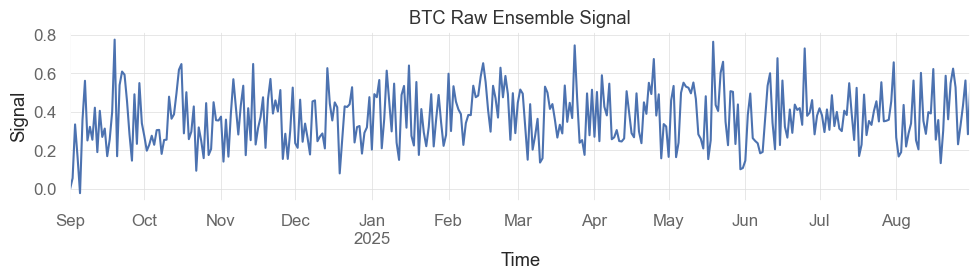

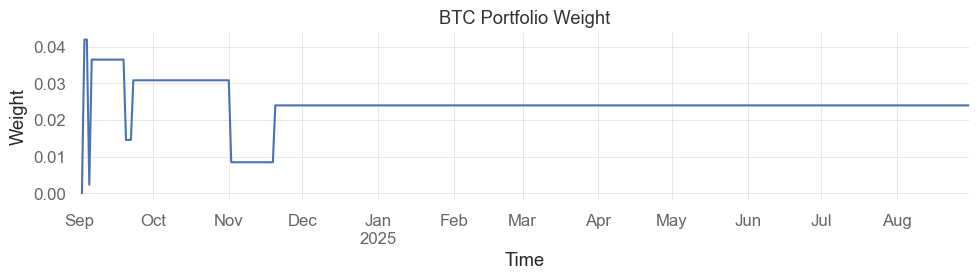

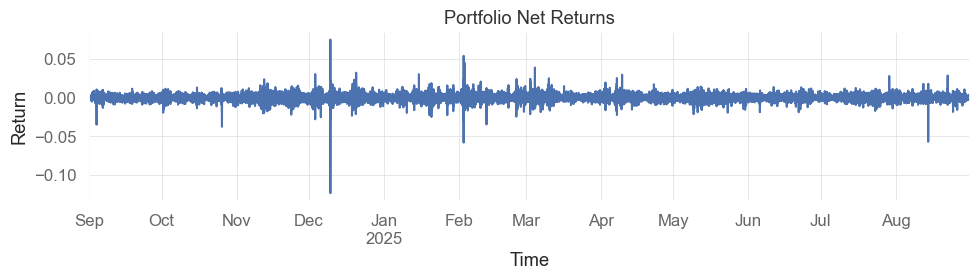

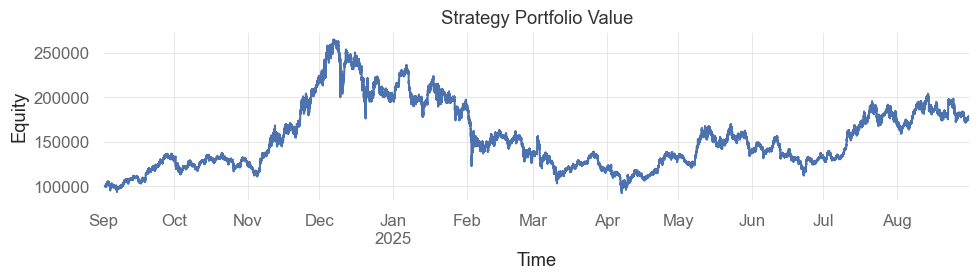

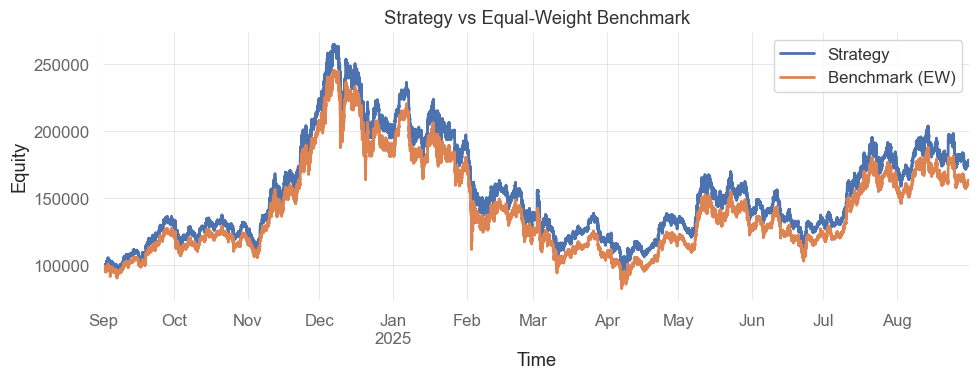

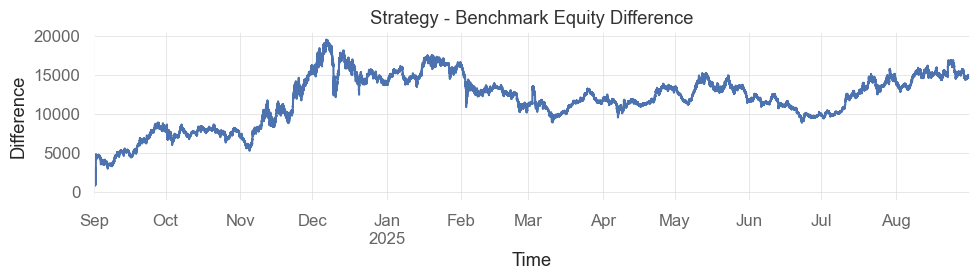

In [16]:
# ---------- Basic config ----------
coin = 'BTC'  # change to any symbol present in your data

# ---------- 1. Raw ensemble signal for chosen coin ----------
plt.figure(figsize=(10, 3))
bt.weights_raw[coin].plot(title=f'{coin} Raw Ensemble Signal')
plt.ylabel('Signal')
plt.xlabel('Time')
plt.tight_layout()

# ---------- 2. Final portfolio weight for chosen coin ----------
plt.figure(figsize=(10, 3))
bt.weights[coin].plot(title=f'{coin} Portfolio Weight')
plt.ylabel('Weight')
plt.xlabel('Time')
plt.tight_layout()

# ---------- 3. Portfolio net returns ----------
plt.figure(figsize=(10, 3))
bt.net_returns.plot(title='Portfolio Net Returns')
plt.ylabel('Return')
plt.xlabel('Time')
plt.tight_layout()

# ---------- 4. Portfolio equity curve ----------
plt.figure(figsize=(10, 3))
bt.equity_curve['portfolio_value'].plot(title='Strategy Portfolio Value')
plt.ylabel('Equity')
plt.xlabel('Time')
plt.tight_layout()

# ---------- 5. Benchmark vs Strategy ----------
bench_equity, bench_returns, bench_metrics = bt.compute_benchmark()

print("Portfolio Risk Metrics:")
print(bt.metrics)
print("\nBenchmark Risk Metrics:")
print(bench_metrics)

alpha, beta, corr = bt.strategy_vs_benchmark(bench_returns)
print("\nStrategy vs Benchmark:")
print(f"Alpha: {alpha:.6f}, Beta: {beta:.4f}, Corr: {corr:.4f}")

plt.figure(figsize=(10, 4))
bt.equity_curve['portfolio_value'].plot(label='Strategy', linewidth=2)
bench_equity.plot(label='Benchmark (EW)', linewidth=2)
plt.title('Strategy vs Equal-Weight Benchmark')
plt.ylabel('Equity')
plt.xlabel('Time')
plt.legend()
plt.tight_layout()

# ---------- 6. PnL vs Benchmark Difference ----------
diff = bt.equity_curve['portfolio_value'] - bench_equity
plt.figure(figsize=(10, 3))
diff.plot(title='Strategy - Benchmark Equity Difference')
plt.ylabel('Difference')
plt.xlabel('Time')
plt.tight_layout()

plt.show()


In [17]:
metric_names = [
    'annualized_return', 'max_drawdown', 'sharpe_ratio', 'sortino_ratio', 'calmar_ratio',
    'num_trades', 'alpha', 'beta', 'correlation'
]

start, end = '2024-09-01 00:00:00', '2025-08-31 23:55:00'
strat_results = {}

def round_metric(val, mult=1.0):
    try: return round(val * mult, 4)
    except: return float('nan')

for strat_cfg in strategies:
    name = type(strat_cfg.strategy).__name__
    bt_ind = Backtester(
        data_dir=bt.data_dir,
        strategies_config=[strat_cfg],
        initial_cash=bt.initial_cash,
        commissions=bt.commissions,
        rebalance=bt.rebalance,
        lambda_value=bt.lambda_value,
        change_threshold=bt.change_threshold,
        start=start,
        end=end
    )
    bench_equity, bench_ret, _ = bt_ind.compute_benchmark()
    alpha, beta, corr = bt_ind.strategy_vs_benchmark(bench_ret)
    m = bt_ind.metrics
    strat_results[name] = {
        'annualized_return': round_metric(m.get('annualized_return')),
        'max_drawdown': round_metric(m.get('max_drawdown')),
        'sharpe_ratio': round_metric(m.get('sharpe_ratio')),
        'sortino_ratio': round_metric(m.get('sortino_ratio')),
        'calmar_ratio': round_metric(m.get('calmar_ratio')),
        'num_trades': round_metric(m.get('num_trades')),
        'alpha': round_metric(alpha, 1e8),
        'beta': round_metric(beta),
        'correlation': round_metric(corr)
    }

# PortfolioStrategy (ensemble)
bench_equity, bench_returns, _ = bt.compute_benchmark()
alpha, beta, corr = bt.strategy_vs_benchmark(bench_returns)
pm = bt.metrics
strat_results['PortfolioStrategy'] = {
    'annualized_return': round_metric(pm.get('annualized_return')),
    'max_drawdown': round_metric(pm.get('max_drawdown')),
    'sharpe_ratio': round_metric(pm.get('sharpe_ratio')),
    'sortino_ratio': round_metric(pm.get('sortino_ratio')),
    'calmar_ratio': round_metric(pm.get('calmar_ratio')),
    'num_trades': round_metric(pm.get('num_trades')),
    'alpha': round_metric(alpha, 1e8),
    'beta': round_metric(beta),
    'correlation': round_metric(corr)
}

# BenchmarkStrategy (equal-weight)
bench_metrics = bt.compute_risk_metrics(bench_returns)
strat_results['BenchmarkStrategy'] = {
    'annualized_return': round_metric(bench_metrics.get('annualized_return')),
    'max_drawdown': round_metric(bench_metrics.get('max_drawdown')),
    'sharpe_ratio': round_metric(bench_metrics.get('sharpe_ratio')),
    'sortino_ratio': round_metric(bench_metrics.get('sortino_ratio')),
    'calmar_ratio': round_metric(bench_metrics.get('calmar_ratio')),
    'num_trades': float('nan'),
    'alpha': float('nan'),
    'beta': float('nan'),
    'correlation': float('nan'),
}

results_df = pd.DataFrame(strat_results).reindex(index=metric_names)
print("\nIndividual Strategy Metrics Table:")
print(results_df)

Alpha: -0.00000083
Beta: 1.00608339
Correlation: 0.99106197
Alpha: -0.00000118
Beta: 0.99267289
Correlation: 0.96673133
Alpha: -0.00000091
Beta: 1.00743858
Correlation: 0.96578795
Alpha: 0.00000129
Beta: 0.94843315
Correlation: 0.89669894
Alpha: 0.00000079
Beta: 1.01312186
Correlation: 0.99621222
Alpha: -0.00000359
Beta: 1.01741525
Correlation: 0.96456054
Alpha: -0.00000050
Beta: 1.00451234
Correlation: 0.95643829
Alpha: 0.00000245
Beta: 0.99259470
Correlation: 0.89222487
Alpha: -0.00000213
Beta: 0.97357438
Correlation: 0.87841823
Alpha: 0.00000579
Beta: 0.96206158
Correlation: 0.90190383
Alpha: 0.00000257
Beta: 0.97238433
Correlation: 0.91046912
Alpha: 0.00000083
Beta: 1.00960350
Correlation: 0.99820988

Individual Strategy Metrics Table:
                   MovingAverageStrategy  BreakoutStrategy  \
annualized_return                 0.4525            0.3732   
max_drawdown                     -0.6453           -0.6973   
sharpe_ratio                      0.8649            0.8000   
so

In [18]:
results_df

,MovingAverageStrategy,BreakoutStrategy,BetaRegressionStrategy,CLV,FourierTransform,AutoRegressiveStrategy,ARMAStrategy,MeanReversionStrategy,VWAPStrategy,Donchian_Breakout,Cross_Sectional_Momentum,PortfolioStrategy,BenchmarkStrategy
annualized_return,0.4525,0.3732,0.4139,0.6799,0.7310,0.0658,0.4643,0.8854,0.1508,1.7063,0.9434,0.7390,0.5948
max_drawdown,-0.6453,-0.6973,-0.6382,-0.6215,-0.6634,-0.7178,-0.6039,-0.6838,-0.6409,-0.5368,-0.6388,-0.6521,-0.6634
sharpe_ratio,0.8649,0.8000,0.8343,1.0277,1.0695,0.5174,0.8742,1.1455,0.6181,1.5572,1.1885,1.0761,0.9760
sortino_ratio,1.2017,1.1143,1.1660,1.4474,1.4862,0.7217,1.2237,1.6214,0.8696,2.1994,1.6764,1.4970,1.3579
calmar_ratio,0.7012,0.5352,0.6486,1.0940,1.1019,0.0917,0.7688,1.2948,0.2353,3.1785,1.4768,1.1333,0.8967
num_trades,350.0000,341.0000,363.0000,186.0000,12.0000,349.0000,352.0000,126.0000,314.0000,254.0000,237.0000,79.0000,NaN
alpha,-83.2930,-118.2170,-90.6250,129.4313,79.3316,-358.6606,-49.8787,245.0753,-212.6549,579.1052,256.9143,82.6305,NaN
beta,1.0061,0.9927,1.0074,0.9484,1.0131,1.0174,1.0045,0.9926,0.9736,0.9621,0.9724,1.0096,NaN
correlation,0.9911,0.9667,0.9658,0.8967,0.9962,0.9646,0.9564,0.8922,0.8784,0.9019,0.9105,0.9982,NaN
